## Leukocytes Image Classification with <b>MONAI DenseNet121</b> and Lightning AI⚡
![img](https://docs.monai.io/projects/monai-deploy-app-sdk/en/0.2.1/_static/MONAI-logo-color.png)
***
Computer vision project _Leukocytes classification from blood smear images - LCBSI_


@AgataPolejowska

### 🔨 📁 Setup the environment - install and import essential packages


In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import plotly" || pip install -q plotly
!python -c "import wandb" || pip install -q wandb
!pip install roboflow --quiet
!pip install -U -q torch
!pip install -U -q torchvision
!python -c "import torchmetrics" || pip install -q torchmetrics
!python -c "import pytorch_lightning" || pip install -q pytorch-lightning

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 1.2 MB 28.4 MB/s 
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'wandb'
     |████████████████████████████████| 1.9 MB 11.3 MB/s 
     |████████████████████████████████| 173 kB 51.8 MB/s 
     |████████████████████████████████| 182 kB 41.0 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 168 kB 55.6 MB/s 
     |████████████████████████████████| 168 kB 61.5 MB/s 
     |████████████████████████████████| 166 kB 60.7 MB/s 
     |████████████████████████████████| 166 kB 60.1 MB/s 
     |████████████████████████████████| 162 kB 57.9 MB/s 
     |████████████████████████████████| 162 kB 54.7 MB/s 
     |████████████████████████████████| 158 kB 51.9 MB/s 
     |████████████████████████████████| 157 kB 73.9 MB/s 
     |████

In [2]:
import os
import numpy as np
from pathlib import Path

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from roboflow import Roboflow

import PIL
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

sns.set_style()

import torch
import torchvision
import torchmetrics

print(torch.__version__)
print(torchvision.__version__)
print(torchmetrics.__version__)

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

print(pl.__version__)

import monai
from monai.config import print_config
from monai.data import DataLoader
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Compose,
)
from monai.utils import set_determinism
from monai.visualize import GradCAM, CAM
from monai.optimizers import LearningRateFinder

1.13.1+cu117
0.14.1+cu117
0.11.0
1.8.5.post0


In [3]:
print_config()

MONAI version: 1.1.dev2251
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 2c97e1a1eea7b3a03f920f5f6e0d412f938906ce
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.9.1
gdown version: 4.4.0
TorchVision version: 0.14.1+cu117
tqdm version: 4.64.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### 📣📉📈 Configure W&B for results monitoring
![img](https://raw.githubusercontent.com/wandb/assets/main/wandb-logo-yellow-dots-black-wb.svg)


Weight and Biases is used as a MLOps platform in order to track the experiments results.

In [4]:
import wandb


wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### 🌱 Ensure results reproducibility by setting the seed for MONAI and Pytorch Lightning

In [5]:
set_determinism(seed=0)
pl.seed_everything(0)

INFO:lightning_lite.utilities.seed:Global seed set to 0


0

### 🔧🔒 Create Pytorch Lightning DataModule - LeukocytesDataModule

This module is created so that all the steps needed to process data are encapsulated and easily reusable.

Within this module the following can be performed:
- setting up the dataset by dowloading it from Roboflow
- getting essential information about the dataset
- visualizing sample images from the dataset
- logging to wandb information about the dataset
- <b>getting dataloaders</b>


The dataset used is created by combining the following datasets:
- RAABINC WBC

_Kouzehkanan, Zahra Mousavi, et al. "A large dataset of white blood cells containing cell locations and types, along with segmented nuclei and cytoplasm." Scientific reports 12.1 (2022): 1-14._
- PBC 

_Acevedo, Andrea; Merino, Anna; Alférez, Santiago; Molina, Ángel; Boldú,
Laura; Rodellar, José (2020), “A dataset for microscopic peripheral blood cell images for development of automatic recognition systems”, Mendeley Data, V1, doi: 10.17632/snkd93bnjr.1_

Data is split to 70% training data, 15% validation data and 15% test data.

5000 images are divided into:

- train data: 3500 images - 700 images per each class (350 for each dataset except basophil class from PBC - 550 images and from RAABIN-WBC - 150 images)
- validation data: 750 images - 150 images per each class (75 for each dataset except basophil class from PBC - 45 images and from RAABIN-WBC - 30 images)
- test data: 750 images - 150 images per each class (75 for each dataset except basophil class from PBC - 45 images and from RAABIN-WBC - 30 images)

In [6]:
class LeukocytesDataModule(pl.LightningDataModule):
    def __init__(
        self,
        batch_size: int = 32,
        num_workers: int = 2,
        num_classes: int = 5,
    ):
        super().__init__()
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.num_workers = num_workers

    def setup(self):
        rf = Roboflow(api_key="3a7r2eyLT0LA2P5AUyvr")
        workspace = rf.workspace("lcbsiwbc")

        project_train = workspace.project("lcbsi-wbc-train")
        dataset_train = project_train.version(1).download("folder")

        project_valid = workspace.project("lcbsi-wbc-valid")
        dataset_valid = project_valid.version(1).download("folder")

        project_test = workspace.project("lcbsi-wbc")
        dataset_test = project_test.version(1).download("folder")

        self.data_dir = "lcbsi_dataset"
        self.path_to_dataset = Path(self.data_dir)
        os.makedirs(self.data_dir, exist_ok=True)

        def move_folder(src, dst):
            import shutil
            for folder in os.listdir(src):
                new_path = os.path.join(dst, folder)
                if os.path.exists(new_path):
                    # if is directory or file remove it
                    if os.path.isdir(new_path):
                        shutil.rmtree(new_path)
                    else:
                        os.remove(new_path)
                os.rename(os.path.join(src, folder), new_path)
        
        move_folder(dataset_train.location, self.data_dir)
        move_folder(dataset_valid.location, self.data_dir)
        move_folder(dataset_test.location, self.data_dir)
    
        print(f"Dataset downloaded to {self.data_dir}")
        print(f"Path to dataset: {self.path_to_dataset}")

    def train_dataset(self, dataset_transforms):
        self.train_dataset = ImageFolder(self.path_to_dataset / "train", dataset_transforms)
        return self.train_dataset

    def val_dataset(self, dataset_transforms):
        self.val_dataset = ImageFolder(self.path_to_dataset / "valid", dataset_transforms)
        return self.val_dataset

    def test_dataset(self, dataset_transforms):
        self.test_dataset = ImageFolder(self.path_to_dataset / "test", dataset_transforms)
        return self.test_dataset

    def train_dataloader(self, batch_size=32):
        return DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self, batch_size=32):
        return DataLoader(
            self.val_dataset, batch_size=batch_size, num_workers=self.num_workers
        )

    def test_dataloader(self, batch_size=32):
        return DataLoader(
            self.test_dataset, batch_size=batch_size, num_workers=self.num_workers
        )

    def visualize_dataset(self, wandb_log=False):
        train_files = []
        for name in self.class_names:
            train_files.extend(
                [
                    os.path.join(self.data_dir, "train", name, x)
                    for x in os.listdir(os.path.join(self.data_dir, "train", name))
                ]
            )
        print(f"Number of train files: {len(train_files)}")

        with PIL.Image.open(train_files[0]) as img:
            img_size = img.size
        print(f"Image size: {img_size}")

        train_files = np.random.choice(train_files, 9, replace=False)
        _, axes = plt.subplots(3, 3, figsize=(12, 12))
        for i, file in enumerate(train_files):
            with PIL.Image.open(file) as img:
                ax = axes[i // 3, i % 3]
                ax.set_title(os.path.basename(os.path.dirname(file)))
                ax.imshow(img)
                ax.axis("off")
                if wandb_log:
                  wandb.log({f"train example image {i}": wandb.Image(img)})
        plt.tight_layout()
        plt.show()

    def get_classes_info(self):
        self.class_names = sorted(
            [
                name
                for name in os.listdir(os.path.join(self.data_dir, "train"))
                if os.path.isdir(os.path.join(self.data_dir, "train", name))
            ]
        )
        num_classes = len(self.class_names)
        print(f"Class names: {self.class_names} ({num_classes} classes)")


In [7]:
NUM_CLASSES = 5
BATCH_SIZE = 32
DATASET_VERSION_NUMBER = 8

In [8]:
leukocytes_data_module = LeukocytesDataModule(batch_size=BATCH_SIZE, num_classes=NUM_CLASSES)
leukocytes_data_module.setup()

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to LCBSI-WBC-TRAIN-1 in folder:: 100%|██████████| 3508/3508 [00:01<00:00, 2623.70it/s]


loading Roboflow project...


Extracting Dataset Version Zip to LCBSI-WBC-VALID-1 in folder:: 100%|██████████| 758/758 [00:00<00:00, 1647.48it/s]

loading Roboflow project...


Extracting Dataset Version Zip to LCBSI-WBC-1 in folder:: 100%|██████████| 758/758 [00:00<00:00, 4410.37it/s]

Dataset downloaded to lcbsi_dataset
Path to dataset: lcbsi_dataset


Class names: ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil'] (5 classes)
Number of train files: 3500
Image size: (256, 256)


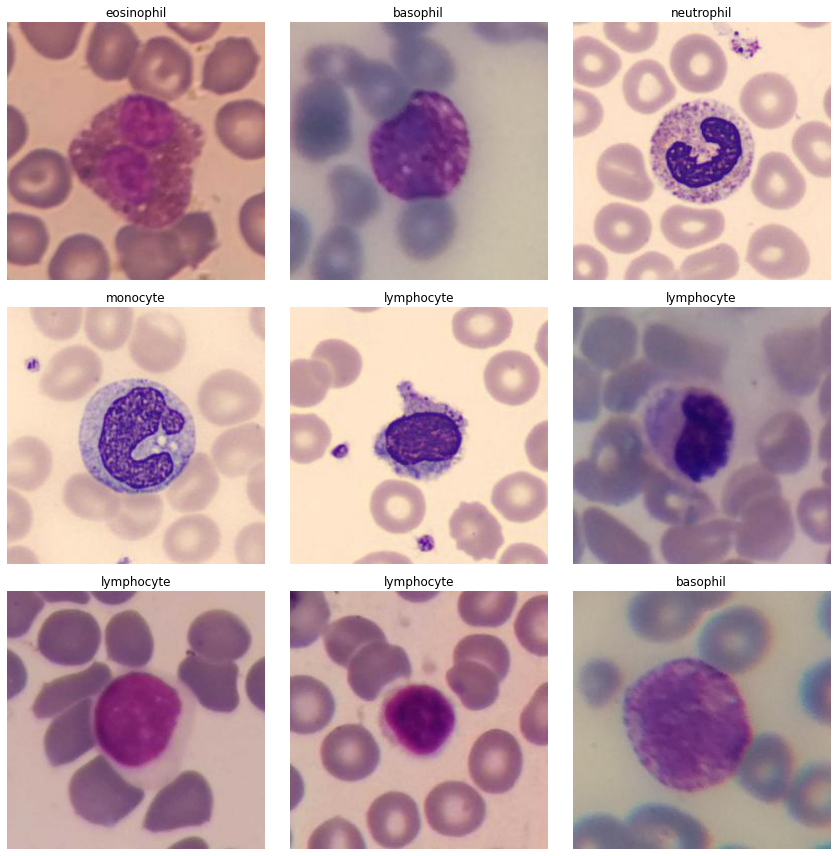

In [9]:
leukocytes_data_module.get_classes_info()
leukocytes_data_module.visualize_dataset()

#### W&B setup

In [11]:
PROJECT = "lcbsi-densenet-monai-ap"
ENTITY = "polejowska"

#### W&B dataset upload as an Artifact

In [12]:
run = wandb.init(project=PROJECT, entity=ENTITY, job_type="upload")

raw_data_artifact = wandb.Artifact("raw_data", type="dataset")
raw_data_artifact.add_dir(leukocytes_data_module.data_dir)

run.log_artifact(raw_data_artifact)

run.finish()

wandb: Currently logged in as: polejowska. Use `wandb login --relogin` to force relogin


wandb: Adding directory to artifact (./lcbsi_dataset)... Done. 6.1s


#### W&B dataset download to track the lineage of models

In [13]:
run = wandb.init(project=PROJECT, entity=ENTITY)

artifact = run.use_artifact(f'{ENTITY}/{PROJECT}/raw_data:v0', type='dataset')

artifact_dir = artifact.download()

wandb: Downloading large artifact raw_data:v0, 34.94MB. 5002 files... 
wandb:   5002 of 5002 files downloaded.  
Done. 0:0:1.9


In [ ]:
leukocytes_data_module.data_dir = artifact_dir
leukocytes_data_module.path_to_dataset = Path(artifact_dir)
leukocytes_data_module.path_to_dataset

#### Transform dataset for training
#### Create dataloaders

In [14]:
IMG_SIZE_RESIZE = (128, 128)

In [15]:
TRANSFORMS = Compose(
    [
        transforms.Resize(IMG_SIZE_RESIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_dataset = leukocytes_data_module.train_dataset(dataset_transforms=TRANSFORMS)
validation_dataset = leukocytes_data_module.val_dataset(dataset_transforms=TRANSFORMS)
test_dataset = leukocytes_data_module.test_dataset(dataset_transforms=TRANSFORMS)

In [16]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 3500
    Root location: lcbsi_dataset/train
    StandardTransform
Transform: <monai.transforms.compose.Compose object at 0x7fa0adc94af0>

In [17]:
validation_dataset

Dataset ImageFolder
    Number of datapoints: 750
    Root location: lcbsi_dataset/valid
    StandardTransform
Transform: <monai.transforms.compose.Compose object at 0x7fa0adc94af0>

In [18]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 750
    Root location: lcbsi_dataset/test
    StandardTransform
Transform: <monai.transforms.compose.Compose object at 0x7fa0adc94af0>

In [19]:
train_dataloader = leukocytes_data_module.train_dataloader()
val_dataloader = leukocytes_data_module.val_dataloader()
test_dataloader = leukocytes_data_module.test_dataloader()

### 🔧🎺 Create Pytorch Lightning Module - Model

This class organizes the code into the most important sections: computations, train loop, validation loop, test loop, prediction loop, optimizers.<br>

In [20]:
class Model(pl.LightningModule):
    def __init__(self, net, criterion, learning_rate, optimizer_class):
        super().__init__()
        self.lr = learning_rate
        self.net = net
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        # self.accuracy = torchmetrics.Accuracy # vscode env
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=5) # colab env
        self.gradcam = monai.visualize.GradCAM(
            self.net, target_layers="class_layers.relu"
        )
        self.cam = monai.visualize.CAM(
            self.net, target_layers="class_layers.relu", fc_layers="class_layers.out"
        )

    def forward(self, x):
        return self.net(x)

    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        return optimizer

    def prepare_batch(self, batch):
        x, y = batch
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        return x.to(device), y.to(device)

    def infer_batch(self, batch):
        x, y = self.prepare_batch(batch)
        y_hat = self.net(x)
        return y_hat, y

    def training_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, logger=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("val_loss", loss, on_step=True, on_epoch=True, logger=True)
        self.log("val_acc", acc, on_step=True, on_epoch=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_acc", acc, prog_bar=True, logger=True)
        return loss

### 🔩📏 Configure the model

1. Model DenseNet121 is initialized using MONAI framework.
2. Pretrained model from _https://github.com/Project-MONAI/model-zoo/releases/tag/hosting_storage_v1_ (_https://github.com/Project-MONAI/model-zoo/tree/dev/models/pathology_nuclei_classification_) is downloaded.
3. First layer and last layers of the pretrained model is adjusted to the corresponding layers in created DenseNet121 model to avoid size mismatch errors regarding input channels number and output channels.
4. Parameters and buffers are copied from pretrained model to created DenseNet121.
5. All layers from denseblock1 to denseblock2 inclusive are frozen so that they won't be trained. The rest of the layers are trained ensuring the model learns to classify leukocytes.

In [21]:
IN_CHANNELS = 3
SPATIAL_DIMS = 2
PRETRAINED = False

model_DenseNet121 = DenseNet121(
    pretrained=PRETRAINED, in_channels=IN_CHANNELS, out_channels=NUM_CLASSES, spatial_dims=SPATIAL_DIMS
)

In [22]:
pretrained_model = monai.bundle.load(
    name="pathology_nuclei_classification", bundle_dir="./", version="0.0.1"
)

pretrained_model["features.conv0.weight"] = model_DenseNet121.features.conv0.weight
pretrained_model["class_layers.out.weight"] = model_DenseNet121.class_layers.out.weight
pretrained_model["class_layers.out.bias"] = model_DenseNet121.class_layers.out.bias

model_DenseNet121.load_state_dict(pretrained_model)

2022-12-18 13:14:20,310 - INFO - --- input summary of monai.bundle.scripts.download ---
2022-12-18 13:14:20,313 - INFO - > name: 'pathology_nuclei_classification'
2022-12-18 13:14:20,317 - INFO - > version: '0.0.1'
2022-12-18 13:14:20,320 - INFO - > bundle_dir: PosixPath('.')
2022-12-18 13:14:20,322 - INFO - > source: 'github'
2022-12-18 13:14:20,325 - INFO - > remove_prefix: 'monai_'
2022-12-18 13:14:20,327 - INFO - > progress: True
2022-12-18 13:14:20,329 - INFO - ---




pathology_nuclei_classification_v0.0.1.zip: 50.8MB [00:00, 122MB/s]                            

2022-12-18 13:14:20,776 - INFO - Downloaded: pathology_nuclei_classification_v0.0.1.zip


2022-12-18 13:14:20,780 - INFO - Expected md5 is None, skip md5 check for file pathology_nuclei_classification_v0.0.1.zip.
2022-12-18 13:14:20,784 - INFO - Writing into directory: ..


<All keys matched successfully>

In [23]:
for param in model_DenseNet121.features.denseblock1.parameters():
    param.requires_grad = False

for param in model_DenseNet121.features.transition1.parameters():
    param.requires_grad = False

for param in model_DenseNet121.features.denseblock2.parameters():
    param.requires_grad = False

for param in model_DenseNet121.features.transition2.parameters():
    param.requires_grad = False

In [24]:
for param in model_DenseNet121.features.denseblock3.parameters():
    param.requires_grad = True

for param in model_DenseNet121.features.transition3.parameters():
    param.requires_grad = True

for param in model_DenseNet121.features.denseblock4.parameters():
    param.requires_grad = True

for param in model_DenseNet121.features.norm5.parameters():
    param.requires_grad = True

for param in model_DenseNet121.class_layers.parameters():
    param.requires_grad = True

### 🔧 Create the Pytorch Lightning Model ⚡ with pretrained model from MONAI 🌐


### 🚅💪 Train the model using Pytorch Lightning ⚡

#### 🕵️ W&B sweep configuration

In [25]:
sweep_config = {
    'method': 'bayes'
}

metric = {
    'name': 'test_acc',
    'goal': 'maximize'   
}

sweep_config['metric'] = metric

In [34]:
# hyperparameters

hyperparameters_dict = {
  'learning_rate': {
      'distribution': 'uniform',
      'min': 0,
      'max': 0.1
    },
  'batch_size': {
      'values': [8, 16, 32, 64, 128]
    },
    'optimizer': {
        'values': ['Adam', 'SGD', 'AdamW']
    },
    'epochs': {
        'value': 10
    },
}

sweep_config['parameters'] = hyperparameters_dict

Error in callback <function _WandbInit._resume_backend at 0x7fa0adc62a60> (for pre_run_cell):


BrokenPipeError: ignored

Error in callback <function _WandbInit._pause_backend at 0x7fa0adc62af0> (for post_run_cell):


BrokenPipeError: ignored

In [28]:
import pprint

pprint.pprint(sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'maximize', 'name': 'test_acc'},
 'parameters': {'batch_size': {'distribution': 'q_log_uniform_values',
                               'max': 256,
                               'min': 32,
                               'q': 8},
                'epochs': {'value': 10},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0},
                'optimizer': {'values': ['Adam', 'SGD', 'AdamW']}}}


In [29]:
sweep_id = wandb.sweep(sweep_config, entity=ENTITY, project=PROJECT)

Create sweep with ID: 37820cim
Sweep URL: https://wandb.ai/polejowska/lcbsi-densenet-monai-ap/sweeps/37820cim


#### W&B configuration for training monitoring

In [30]:
class ImagePredictionLogger(Callback):
    def __init__(self, val_samples, num_samples=32):
        super().__init__()
        self.num_samples = num_samples
        self.val_imgs, self.val_labels = val_samples


early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=3,
    verbose=False,
    mode='min'
)

checkpoint_callback = ModelCheckpoint(monitor='val_acc', mode='max')

CALLBACKS = [ImagePredictionLogger(next(iter(test_dataloader))), checkpoint_callback]
LOG_EVERY_N_STEPS = 5
CRITERION = torch.nn.CrossEntropyLoss()

In [31]:
def get_optimizer_class(optimizer_name):
    if optimizer_name == 'Adam':
        return torch.optim.Adam
    elif optimizer_name == 'SGD':
        return torch.optim.SGD
    elif optimizer_name == 'AdamW':
        return torch.optim.AdamW
    else:
        raise ValueError(f'Optimizer {optimizer_name} is not supported')

In [32]:
def sweep(config=None):

    with wandb.init(config=config) as run:
        config = run.config
        
        logger = pl.loggers.WandbLogger(experiment=run, log_model=True)

        gpus = -1 if torch.cuda.is_available() else 0

        trainer = pl.Trainer(
            gpus=gpus,
            max_epochs=config.epochs,
            logger=logger,
            callbacks=CALLBACKS,
            log_every_n_steps=LOG_EVERY_N_STEPS,
            enable_progress_bar=True,
            enable_model_summary=True,
        )

        optimizer_class = get_optimizer_class(config.optimizer)
  
        model = Model(model_DenseNet121, CRITERION, config.learning_rate, optimizer_class)

        train_data_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        val_data_loader = DataLoader(validation_dataset, batch_size=config.batch_size, shuffle=False)
        test_data_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

        trainer.fit(model, train_data_loader, val_data_loader)
        trainer.validate(model, val_data_loader)
        trainer.test(model, test_data_loader)

        torch.save(model.state_dict(), f"model_{run.name}.pt")
        model_artifact = wandb.Artifact(
            f"model_{run.name}", type="model", description="Model generated using a sweep"
        )
        model_artifact.add_file(f"model_{run.name}.pt")
        run.log_artifact(model_artifact)

In [33]:
wandb.agent(sweep_id, sweep, count=5)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: hfqawktl with config:
wandb: 	batch_size: 88
wandb: 	epochs: 10
wandb: 	learning_rate: 0.05167824549409825
wandb: 	optimizer: Adam


Providing log_model=True requires wandb version >= 0.10.22 for logging associated model metadata.
Hint: Upgrade with `pip install --upgrade wandb`.
Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | net       | DenseNet121        | 7.0 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
--------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_acc_epoch         0.7893333435058594
     val_loss_epoch         0.6734067797660828
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7666666507720947
        test_loss           0.8314535021781921
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
test_acc,▁
test_loss,▁
train_acc_epoch,▁▄▆▇▇▇████
train_acc_step,▁▄▂▂▄▆▅▆▆▆▆▆▇▇▇▇▇▇▇█▇▇▇███▇█▇███████████
train_loss_epoch,█▃▂▂▂▁▁▁▁▁
train_loss_step,█▃▄▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▁▁▃▃▁▃▃▁▂▄▄▂▂▅▅▂▂▆▆▂▆▆▂▂▇▇▂▂██▂▃▁█
val_acc_epoch,▁▅▅▅▆▅▇▇▅██
val_acc_step,▅▁▇▂▅▄▄▇▄█▃▇█▄▄▅▅▇▆▂▅▄▇▆▆▅▇▅▆▂▅█▆▇▇▄██▆▇
val_loss_epoch,█▂▂▃▂▃▂▂▃▁▁


wandb: Agent Starting Run: yt3rmwge with config:
wandb: 	batch_size: 48
wandb: 	epochs: 10
wandb: 	learning_rate: 0.07285339855782418
wandb: 	optimizer: SGD


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
Checkpoint directory ./lightning_logs/hfqawktl/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | net       | DenseNet121        | 7.0 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
---------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_acc_epoch         0.8960000276565552
     val_loss_epoch         0.33421361446380615
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8573333621025085
        test_loss           0.4157310724258423
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
test_acc,▁
test_loss,▁
train_acc_epoch,▁▅▅▇▆▇▇█▇█
train_acc_step,▃▂▆▄▅▃▄▄▆▅▄▄▃▅▅▅▄▅▅█▆▅▄▄▄▆▁▆▅▃▆▂▇▆▆▅▅▆▆▇
train_loss_epoch,█▄▃▃▂▂▂▁▂▁
train_loss_step,█▆▄▄▄▆▇▄▃▇▇▃▆▄█▃▇▅▄▁▆▅▇▃▅▃█▇▃█▇█▂▇▃▃█▃▃▃
trainer/global_step,▁▂▁▁▂▂▁▂▃▁▁▃▄▁▂▄▄▂▂▅▅▂▂▆▂▂▆▆▂▂▇▇▂▂██▂▂▁▁
val_acc_epoch,▁▃▆▇▄▆▇▇█▆▆
val_acc_step,███▁█▇▇▇▇█▃██▇▇▇▇▇█▇█▃█▇▇▇██▃██▇▇▇▇▃▇██▇
val_loss_epoch,█▆▄▁▄▄▂▁▂▂▂


wandb: Agent Starting Run: 0co0yaza with config:
wandb: 	batch_size: 248
wandb: 	epochs: 10
wandb: 	learning_rate: 0.056107861601780135
wandb: 	optimizer: AdamW


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | net       | DenseNet121        | 7.0 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
5.5 M     Trainable params
1.4 M     Non-trainabl

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_acc_epoch         0.8373333215713501
     val_loss_epoch         0.5066191554069519
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8106666803359985
        test_loss           0.6496570706367493
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
test_acc,▁
test_loss,▁
train_acc_epoch,▁▅▅▇▆▇▇▇██
train_acc_step,▂▄▅▄▆▁▆▄▂▇▆▃▆▅▆▆▆▅▅▆▃▆▇▆▆▇▃▅▇█
train_loss_epoch,█▃▃▂▂▂▂▁▁▁
train_loss_step,▆▅▅▄▃▆▂▅▅▁▂▇▃▃▃▂▂▄▄▃▄▂▂▂▂▂█▂▂▁
trainer/global_step,▁▂▁▂▂▁▁▂▃▁▂▃▄▂▄▄▄▂▄▅▂▂▅▆▂▂▆▇▂▇▇▂▃▇█▃▃▁▁█
val_acc_epoch,▁▃▅█▃▆▆█▇██
val_acc_step,▅▃▂▁▃▅▅▆▇▆▆▆▇▇▇▄▆▄▆▇▅▆▆▆▆▇▇▇▇█▆█▇▇▇▇█▇▇█
val_loss_epoch,█▆▂▁▅▂▂▁▁▁▁


wandb: Agent Starting Run: qmyzztz4 with config:
wandb: 	batch_size: 112
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0986216488943732
wandb: 	optimizer: AdamW


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | net       | DenseNet121        | 7.0 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
5.5 M     Trainable params
1.4 M     Non-trainabl

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_acc_epoch         0.9253333210945129
     val_loss_epoch         0.3101280927658081
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9039999842643738
        test_loss           0.34140393137931824
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
test_acc,▁
test_loss,▁
train_acc_epoch,▁▅▆▆▅▆▇███
train_acc_step,▁▁▄▅▅▅▄▄▅▆▅▅▄▅▇▃▅▅▅▃▇▇▇▇▇▇▆█▆▆▇▇▇▆▇▇▆▆▆▇
train_loss_epoch,█▄▃▂▄▃▂▁▁▁
train_loss_step,█▇▅▄▃▃▃▅▅▃▄▄▄▃▂▆▄▄▄▆▃▃▂▂▂▃▂▁▃▂▂▁▁▂▁▂▂▃▃▂
trainer/global_step,▁▂▁▂▂▁▁▂▃▁▁▃▃▁▂▄▄▂▂▅▂▂▅▆▂▂▆▆▂▂▇▇▂▂▇█▂▂▁█
val_acc_epoch,▄▁▇▇▆▅▇▆▇██
val_acc_step,▂▅▆▇▁▆▃▂▆▇▆▆█▆███▄▅█▅▆▅██▇▅▇▇▇▇████▇▇███
val_loss_epoch,▃█▁▂▂▄▂▃▁▁▁


wandb: Agent Starting Run: y4chd6ht with config:
wandb: 	batch_size: 48
wandb: 	epochs: 10
wandb: 	learning_rate: 0.07143291313572404
wandb: 	optimizer: SGD


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | net       | DenseNet121        | 7.0 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
5.5 M     Trainable params
1.4 M     Non-trainabl

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_acc_epoch         0.9493333101272583
     val_loss_epoch         0.20440112054347992
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9279999732971191
        test_loss            0.250031054019928
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
test_acc,▁
test_loss,▁
train_acc_epoch,▁▅▅▆▇█▆▇██
train_acc_step,▅▅▇▄▅▇███▅▅▇▄▅▇▅▄▄▇█▇▅▅▇██▄▇█▁▄▄▇█▅▇▁█▅█
train_loss_epoch,█▄▄▂▁▂▂▂▂▁
train_loss_step,▄▃▂▄▆▂▁▂▂▃▃▃▅▃▂▄▄▅▂▁▃▃▃▂▂▂▅▃▁▆▄▅▃▂▂▂█▁▃▂
trainer/global_step,▁▂▁▁▂▂▁▂▃▁▁▃▄▁▂▄▄▂▂▅▅▂▂▆▂▂▆▆▂▂▇▇▂▂██▂▂▁▁
val_acc_epoch,▃▅▃▅▁▅▄▄█▅▅
val_acc_step,▇█▇▁▇▅▆▃▂▇▂▇█▆▃▂▄▆▇█▇▂▂▄▆▆█▇▂▇█▆▅▄▄▄▇█▇▆
val_loss_epoch,▇▇▅▁▆▄▅▄▆██


Error in callback <function _WandbInit._pause_backend at 0x7fa0adc62af0> (for post_run_cell):


BrokenPipeError: ignored